#  IHDP A example
We use S-KAAMs to perform inference and interprete results in IHDP A, a dataset with linear homogeneous effects.

Therefore, we will visualize the learned representations for one realization of this dataset and model.

In [1]:
#imports
import numpy as np
import pandas as pd
import torch
import time

from utils import load_data
from sklearn.model_selection import train_test_split
from kan_model import kan_net
from mlp_model import mlp_net
from utils import get_width, get_dims_mlp
from representation import *
from tueplots import bundles, figsizes, axes
import copy
import matplotlib.pyplot as plt
from experiment_symbolic import *

In [2]:
# seed
np.random.seed(42)
torch.manual_seed(42)

In [3]:
#load the data
i = 2
split = 0.2

data_train, data_test = load_data('IHDP_A', i)
col_names = data_train.columns
x_cols = [col for col in data_train.columns if 'x' in col]

x_train, y_train, t_train = data_train[x_cols].values, data_train['y_factual'].values[:, None], data_train['treatment'].values[:, None]
x_test, y_test, t_test = data_test[[col for col in data_test.columns if 'x' in col]].values, data_test['y_factual'].values[:, None], data_test['treatment'].values[:, None]

x_train, x_val, y_train, y_val, t_train, t_val = train_test_split(x_train, y_train, t_train, test_size=split, shuffle=False)

real_ite_train = data_train['mu1'].values - data_train['mu0'].values
real_ite_test = data_test['mu1'].values - data_test['mu0'].values

real_ite_train, real_ite_val = real_ite_train[:x_train.shape[0]], real_ite_train[x_train.shape[0]:]
print(col_names)
print(x_cols)

data_test_t0 = data_test.copy()
data_test_t0['treatment'] = 0
data_test_t1 = data_test.copy()
data_test_t1['treatment'] = 1

Index(['treatment', 'y_factual', 'y_cfactual', 'mu0', 'mu1', 'x1', 'x2', 'x3',
       'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14',
       'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24',
       'x25'],
      dtype='object')
['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25']


In [4]:
# preprocess the data
print(x_train.shape, y_train.shape, t_train.shape, x_val.shape, y_val.shape, t_val.shape, x_test.shape, y_test.shape, t_test.shape, real_ite_train.shape, real_ite_test.shape, real_ite_val.shape)

(538, 25) (538, 1) (538, 1) (135, 25) (135, 1) (135, 1) (74, 25) (74, 1) (74, 1) (538,) (74,) (135,)


In [5]:
# instanciate the KAN model
# T-KAAM
width = get_width('slearner', x_train.shape[1], hidden_dims = [], mult_kan=False)
s_kaam = kan_net('slearner', width, grid=3, k=3, sparse_init=False, try_gpu=False, real_ite_train=real_ite_train, real_ite_test=real_ite_val, save_folder='visualization/checkpoint')

checkpoint directory created: C:\Users\Alex\CODE\causalkans\visualization/checkpoint\kan_345353\
saving model version 0.0


In [6]:
#train the model
tic = time.time()
results = s_kaam.fit(x_train, y_train, t_train, x_val, y_val, t_val, early_stop=True, patience=30, batch=1000,
                           steps=10000, lamb=0.01, lamb_entropy=0.1,  lr=0.001, verbose=0)
tac = time.time()
print(results.keys())
print('Training time: ', tac - tic)

Early stopping at step 5447
saving model version 0.1
dict_keys(['train_loss', 'test_loss', 'reg', 'train_metrics', 'test_metrics'])
Training time:  80.53171920776367


In [7]:
prediction = s_kaam.predict(x_test, t_test)
print(prediction.keys())
prediction['ite']= prediction['y_pred_1'] - prediction['y_pred_0']

dict_keys(['y_pred_f', 'y_pred_cf', 'y_pred_0', 'y_pred_1', 'pred_best_treatment'])


In [50]:
# Compute prediction metrics in MSE of factual outcome and
mse = np.mean((y_test.squeeze() - prediction['y_pred_f'])**2)
pehe = np.sqrt(np.mean((real_ite_test - prediction['ite'])**2))
print(f'MSE original KAN: {mse}, PEHE original KAN: {pehe}')
print(f'Predicted ATE: {prediction["ite"].mean()}, Real ATE: {real_ite_test.mean()}')
print(f'ATE error: {abs(prediction["ite"].mean() - real_ite_test.mean())}')

MSE original KAN: 1.34121568241401, PEHE original KAN: 1.1517857945855567
Predicted ATE: 3.7395031452178955, Real ATE: 3.972216552912336
ATE error: 0.23271340769444038


In [9]:
# MLP params = hidden_dims= [100, 100, 100], dropout=0.0, lr=1e-05, activation=leaky_relu
dims_mlp = get_dims_mlp('tlearner', x_train.shape[1], hidden_dims=[100, 100, 100])
s_nn = mlp_net('tlearner', dims_mlp, dropout=0.0, activation='leaky_relu', try_gpu=False, save_folder='visualization/checkpoint', real_ite_train = real_ite_train, real_ite_test = real_ite_val)
tic = time.time()
results_mlp = s_nn.fit(x_train, y_train, t_train, x_val, y_val, t_val, early_stop=True, patience=30, batch=1000,
                           steps=10000, lr=1e-5, verbose=0)
tac = time.time()
print(results_mlp.keys())
print('Training time MLP: ', tac - tic)


Early stopping at step 4827
dict_keys(['train_loss', 'test_loss', 'reg', 'train_metrics', 'test_metrics'])
Training time MLP:  64.91554713249207


In [49]:
prediction_mlp = s_nn.predict(x_test, t_test)
prediction_mlp['ite']= prediction_mlp['y_pred_1'] - prediction_mlp['y_pred_0']
y_pred_f_mlp = t_test.squeeze()*prediction_mlp['y_pred_1'] + (1 - t_test.squeeze())*prediction_mlp['y_pred_0']
mse_mlp = np.mean((y_test.squeeze() -y_pred_f_mlp)**2)
pehe_mlp = np.sqrt(np.mean((real_ite_test - prediction_mlp['ite'])**2))
print(f'MSE MLP: {mse_mlp}, PEHE MLP: {pehe_mlp}')
print(f'Predicted ATE MLP: {prediction_mlp["ite"].mean()}, Real ATE: {real_ite_test.mean()}, Error: {abs(prediction_mlp["ite"].mean() - real_ite_test.mean())}')

MSE MLP: 1.4862283683040258, PEHE MLP: 1.0140916473248311
Predicted ATE MLP: 3.5868430137634277, Real ATE: 3.972216552912336, Error: 0.38537353914890815


In [11]:
print(results.keys())

dict_keys(['train_loss', 'test_loss', 'reg', 'train_metrics', 'test_metrics'])


In [12]:
# formula without pruning
symb_s_kaam_orig = symbolic_kan_regressor(x_names = x_cols + ['treatment'], y_names=['y_factual'])

In [13]:
with plt.rc_context({**bundles.iclr2024()}):
    tic = time.time()
    xt_train = np.concatenate((x_train, t_train), axis=1)
    xt_val = np.concatenate((x_val, t_val), axis=1)
    out_0 = symb_s_kaam_orig.fit(s_kaam.model, xt_train, y_train, xt_val, y_val, denorm_function=None, stochastic=False, r2_threshold=0.98, show_results=False, save_dir = 'visualization/formulas')
    tac = time.time()
    print('Formula extraction time (control): ', tac - tic)

formula_orig = symb_s_kaam_orig.get_formula()

Found polynomial of degree 1 for input 1/26 and output 1/1 with r2 0.9807. Total time: 0.00s, Iteration time: 0.00s, Average time per output: 0.00s
Found polynomial of degree 3 for input 2/26 and output 1/1 with r2 0.9974. Total time: 0.77s, Iteration time: 0.00s, Average time per output: 0.39s
Found polynomial of degree 2 for input 3/26 and output 1/1 with r2 0.9985. Total time: 1.19s, Iteration time: 0.00s, Average time per output: 0.40s
Found polynomial of degree 3 for input 4/26 and output 1/1 with r2 1.0000. Total time: 1.54s, Iteration time: 0.02s, Average time per output: 0.38s
Found polynomial of degree 1 for input 5/26 and output 1/1 with r2 0.9875. Total time: 1.91s, Iteration time: 0.00s, Average time per output: 0.38s
Found polynomial of degree 4 for input 6/26 and output 1/1 with r2 0.9977. Total time: 2.29s, Iteration time: 0.02s, Average time per output: 0.38s
Found polynomial of degree 1 for input 7/26 and output 1/1 with r2 1.0000. Total time: 2.65s, Iteration time: 0.

In [14]:
print(formula_orig[0])

3.7395*treatment + 0.5294*x1 + 0.1608*x10 + 0.5895*x11 - 0.1099*x12 + 0.3351*x13 + 0.0001*x14 - 0.e-4*x15 + 0.108*x16 - 0.0003*x17 - 0.1713*x18 + 1.2755*x19 + 0.0093*x2**3 - 0.0078*x2**2 - 0.0046*x2 - 0.2308*x20 - 0.0823*x21 - 0.0552*x22 - 0.e-4*x23 + 0.1115*x24 + 0.018*x25 + 0.1835*x3**2 + 1.2915*x3 - 0.0125*x4**3 + 0.0356*x4**2 + 0.0084*x4 + 0.2846*x5 + 0.0096*x6**4 - 0.0345*x6**3 - 0.0025*x6**2 + 0.0267*x6 - 0.e-4*x7 + 1.4696*x8 + 0.3173*x9 + 3.1752


 # PRUNING AND FORMULA EXTRACTION

In [15]:
# pruning and evaluation
# t_kaam_original = copy.deepcopy(t_kaam)
tic = time.time()
s_kaam_pruned = s_kaam.prune(node_th=1e-2, edge_th=1e-2)
tac = time.time()
print('Pruning time: ', tac - tic)

saving model version 0.2
Pruning time:  0.015637636184692383


In [46]:
#evaluate
predictions_pruned = s_kaam.predict(x_test, t_test)
predictions_pruned['ite']= predictions_pruned['y_pred_1'] - predictions_pruned['y_pred_0']
y_pred_f = t_test*predictions_pruned['y_pred_1'] + (1 - t_test)*predictions_pruned['y_pred_0']
mse_pruned = np.mean((y_test.squeeze() - predictions_pruned['y_pred_f'])**2)
# mse_pruned = np.mean((y_test - y_pred_f)**2)
pehe_pruned = np.sqrt(np.mean((real_ite_test - predictions_pruned['ite'])**2))
print(f'MSE pruned KAN: {mse_pruned}, PEHE pruned KAN: {pehe_pruned}')
print(f'Predicted ATE: {predictions_pruned["ite"].mean()}, Real ATE: {real_ite_test.mean()}')
print(f'ATE error: {abs(predictions_pruned["ite"].mean() - real_ite_test.mean())}')

MSE pruned KAN: 2.8223613522406295, PEHE pruned KAN: 1.1517856997903473
Predicted ATE: 3.739501953125, Real ATE: 3.972216552912336
ATE error: 0.23271459978733589


In [17]:
# formula extraction
symb_s_kaam = symbolic_kan_regressor(x_names = x_cols + ['treatment'], y_names=['y_factual'])


In [18]:
with plt.rc_context({**bundles.iclr2024()}):
    tic = time.time()
    xt_train = np.concatenate((x_train, t_train), axis=1)
    xt_val = np.concatenate((x_val, t_val), axis=1)
    out_0 = symb_s_kaam.fit(s_kaam.model, xt_train, y_train, xt_val, y_val, denorm_function=None, stochastic=False, r2_threshold=0.98, show_results=False, save_dir = 'visualization/formulas')
    tac = time.time()
    print('Formula extraction time (control): ', tac - tic)


Found polynomial of degree 1 for input 1/26 and output 1/1 with r2 0.9807. Total time: 0.00s, Iteration time: 0.00s, Average time per output: 0.00s
Found polynomial of degree 3 for input 2/26 and output 1/1 with r2 0.9974. Total time: 0.32s, Iteration time: 0.00s, Average time per output: 0.16s
Found polynomial of degree 2 for input 3/26 and output 1/1 with r2 0.9985. Total time: 0.71s, Iteration time: 0.00s, Average time per output: 0.24s
Found polynomial of degree 0 for input 4/26 and output 1/1 with r2 1.0000. Total time: 1.05s, Iteration time: 0.00s, Average time per output: 0.26s
Found polynomial of degree 1 for input 5/26 and output 1/1 with r2 0.9875. Total time: 1.39s, Iteration time: 0.00s, Average time per output: 0.28s
Found polynomial of degree 4 for input 6/26 and output 1/1 with r2 0.9977. Total time: 1.75s, Iteration time: 0.00s, Average time per output: 0.29s
Found polynomial of degree 0 for input 7/26 and output 1/1 with r2 1.0000. Total time: 2.11s, Iteration time: 0.

In [19]:
formulas = symb_s_kaam.get_formula()

In [20]:
# evaluate formula performance
xt_test = np.concatenate((x_test, t_test), axis=1)
xt_0 = np.concatenate((x_test, np.zeros((x_test.shape[0], 1))), axis=1)
xt_1 = np.concatenate((x_test, np.ones((x_test.shape[0], 1))), axis=1)
y_pred_0 = symb_s_kaam.predict(xt_0)
y_pred_1 = symb_s_kaam.predict(xt_1)
y_pred_f = symb_s_kaam.predict(xt_test)
ite_pred = y_pred_1 - y_pred_0
mse_formula = np.mean((y_test - y_pred_f)**2)
pehe_formula = np.sqrt(np.mean((real_ite_test - ite_pred)**2))
print(f'MSE formula: {mse_formula}, PEHE formula: {pehe_formula}')
print(f'Predicted ATE formula: {ite_pred.mean()}, Real ATE: {real_ite_test.mean()}')


MSE formula: 2.75956977358088, PEHE formula: 1.1517854382363386
Predicted ATE formula: 3.7395033240318427, Real ATE: 3.972216552912336


In [21]:
print(formulas)

[3.7395*treatment + 0.5294*x1 + 0.1608*x10 + 0.5895*x11 - 0.1099*x12 + 0.3351*x13 + 0.108*x16 - 0.1713*x18 + 1.2755*x19 + 0.0093*x2**3 - 0.0078*x2**2 - 0.0046*x2 - 0.2308*x20 - 0.0823*x21 + 0.1115*x24 + 0.1835*x3**2 + 1.2915*x3 + 0.2846*x5 + 0.0096*x6**4 - 0.0345*x6**3 - 0.0025*x6**2 + 0.0267*x6 + 1.4696*x8 + 0.3173*x9 + 1.8812]


In [22]:
# extract the CATE
# in this case the CATE is the term that corresponds to the treatment 't'
# Break into additive terms
terms = formulas[0].as_ordered_terms()

# Keep only those that depend on 't'
terms_t = [term for term in terms if term.has(sp.symbols('treatment'))]

# Rebuild the expression
cate_formula = sp.Add(*terms_t)



In [23]:
print(cate_formula)

coef = sp.poly(cate_formula, sp.symbols('treatment')).coeffs()[0]

3.7395*treatment


In [42]:
# real_ite_test = 4*np.ones(real_ite_test.shape) # in this dataset the treatment effect is constant and equal to 4
real_ite_test =  data_test['mu1'].values - data_test['mu0'].values

In [43]:
ite_pred_formula = eval_expr_on_df(cate_formula, data_test_t1) - eval_expr_on_df(cate_formula, data_test_t0)
pehe_formula_cate = np.sqrt(np.mean((real_ite_test - ite_pred_formula)**2))
print(f'PEHE formula cate: {pehe_formula_cate}')
print(f'Predicted ATE formula cate: {ite_pred_formula.mean()}, Real ATE: {real_ite_test.mean()}')

PEHE formula cate: 1.151786109847089
Predicted ATE formula cate: 3.739500000000001, Real ATE: 3.972216552912336


In [44]:
# round formulas and compute metrics again
formula_rounded = sp.sympify(sp.nsimplify(formulas[0], tolerance=1e-2))

y_pred_0_trunc = eval_expr_on_df(formula_rounded, data_test_t0)
y_pred_1_trunc = eval_expr_on_df(formula_rounded, data_test_t1)
y_pred_f_trunc = eval_expr_on_df(formula_rounded, data_test)
ite_pred_trunc = y_pred_1_trunc - y_pred_0_trunc
mse_formula_trunc = np.mean((y_test[:,0] - y_pred_f_trunc)**2)
pehe_formula_trunc = np.sqrt(np.mean((real_ite_test - ite_pred_trunc)**2))
print(f'MSE formula truncated: {mse_formula_trunc}, PEHE formula truncated: {pehe_formula_trunc}')
print(f'Predicted ATE formula truncated: {ite_pred_trunc.mean()}, Real ATE: {real_ite_test.mean()}')


MSE formula truncated: 2.7549395515007955, PEHE formula truncated: 1.151769275371149
Predicted ATE formula truncated: 3.739583333333333, Real ATE: 3.972216552912336


In [27]:
#print pehe with cate formula truncated
cate_formula_trunc =  sp.sympify(sp.nsimplify(cate_formula, tolerance=1e-2))
ite_pred_formula_trunc = eval_expr_on_df(cate_formula_trunc, data_test_t1) - eval_expr_on_df(cate_formula_trunc, data_test_t0)
pehe_formula_cate_trunc = np.sqrt(np.mean((real_ite_test - ite_pred_formula_trunc)**2))
print(f'PEHE formula cate truncated: {pehe_formula_cate_trunc}')
print(f'Predicted ATE formula cate truncated: {ite_pred_formula_trunc.mean()}, Real ATE: {real_ite_test.mean()}')

PEHE formula cate truncated: 0.2604166666666665
Predicted ATE formula cate truncated: 3.739583333333333, Real ATE: 4.0


In [28]:
present = {s.name for s in formulas[0].free_symbols}
print(present)

{'x10', 'x8', 'x19', 'x24', 'x12', 'x5', 'x11', 'x2', 'x1', 'x3', 'x16', 'x21', 'x20', 'x18', 'x13', 'treatment', 'x6', 'x9'}


In [29]:
ausent = set(x_cols) - present
print(ausent)

{'x4', 'x7', 'x14', 'x23', 'x17', 'x22', 'x15', 'x25'}


In [30]:
n_feats = len(list(present))

# Radar plots for given patients (factual outcome)

In [31]:
x_train_df = pd.DataFrame(xt_train, columns=x_cols + ['treatment'])
delta_formula, delta_train= get_delta(x_train_df, formulas[0])



In [32]:
delta_train = delta_train[0].iloc[:, :-1]

In [33]:

cols_delta = delta_train.columns
# modifty cols_delta to be in the same order as x_cols
cols_delta = [col for col in x_cols if col in cols_delta] + ['treatment']
delta_train = delta_train[cols_delta]

C:\Users\Alex\AppData\Local\Temp\ipykernel_31604\3778131757.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


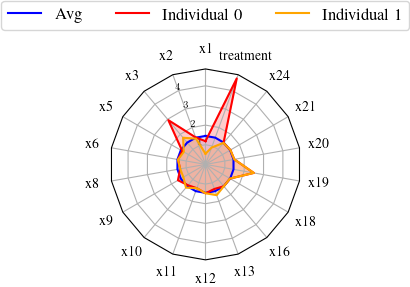

In [34]:
theta = radar_factory(n_feats, frame='polygon')
patient_ids = [0,1]
# set different patient colors: red and orange
colors = ['r', 'orange']
with plt.rc_context({**bundles.iclr2024()}):
    fig, ax = plt.subplots(subplot_kw=dict(projection='radar'))
    # ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    avg_delta = sum(np.mean(delta_train, axis=0)) * np.ones(n_feats)

    _ = ax.plot(theta, avg_delta, label='Avg', color='b')
    ax.fill(theta, avg_delta, alpha=0.1, color='b')

    avg_delta_ = delta_train.mean(axis=0).values[None, :]
    avg_matrix = np.repeat(avg_delta_, delta_train.shape[1], axis=0)

    for j, patient_id in enumerate(patient_ids):
        np.fill_diagonal(avg_matrix, delta_train.iloc[patient_id].values)
        pat_proba = avg_matrix.sum(axis=1)
        _ = ax.plot(theta, pat_proba, label=f'Individual {patient_id}', color=colors[j])
        ax.fill(theta, pat_proba, alpha=0.2, color=colors[j])

    ax.set_varlabels(cols_delta, fontsize=10)
    # legend above the radar plot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=3, fontsize=12)
    plt.tight_layout()
    plt.savefig('visualization/radar_skaam.pdf', bbox_inches='tight')
    plt.show()


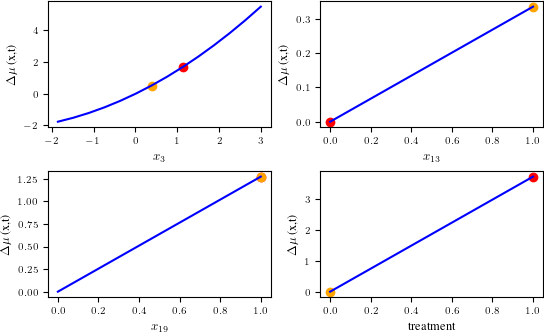

In [35]:
# PDP on each feature
# we will represent only the most important variables based on the radar plot
important_vars = ['x3', 'x13', 'x19', 'treatment']
with plt.rc_context({**bundles.iclr2024(), **figsizes.iclr2024(ncols=2, nrows=2)}):
    fig, axs = plt.subplots(nrows=2, ncols=2)

    for i, var in enumerate(important_vars):
        row = i // 2
        col = i % 2
        ax = axs[row, col]

        # plot the value of delta_train[var] against x_train_df[var] ordered with plot
        sorted_idx = np.argsort(x_train_df[var])
        ax.plot(x_train_df[var].values[sorted_idx], delta_train[var].values[sorted_idx], color='b')
        # change the name var (format x25) to latex version x_{25}
        var_latex = var.replace('x', 'x_{') + '}'
        if var != 'treatment':
            ax.set_xlabel(f'${var_latex}$')
        else:
            ax.set_xlabel('treatment')

        ax.set_ylabel(r'$\Delta \mu$ (x,t) ')

        # represent the points of the patients of patients_id
        for j, patient_id in enumerate(patient_ids):
            ax.scatter(x_train_df[var].values[patient_id], delta_train[var].values[patient_id], color=colors[j], label=f'Individual {patient_id}')

    plt.savefig('visualization/pdps_skaam.pdf')
    plt.show()

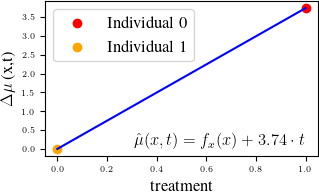

In [36]:
# represent also one plot alone
with plt.rc_context({**bundles.icml2024(column='half')}):
    var = 'treatment'
    fig, ax = plt.subplots()

    # plot the value of delta_train[var] against x_train_df[var] ordered with plot
    sorted_idx = np.argsort(x_train_df[var])
    ax.plot(x_train_df[var].values[sorted_idx], delta_train[var].values[sorted_idx], color='b')
    # change the name var (format x25) to latex version x_{25}
    # var_latex = var.replace('x', 'x_{') + '}'
    ax.set_xlabel(f'treatment', fontsize = 12)

    ax.set_ylabel(r'$\Delta \mu $ (x,t)', fontsize = 12)

    # represent the points of the patients of patients_id
    for j, patient_id in enumerate(patient_ids):
        ax.scatter(x_train_df[var].values[patient_id], delta_train[var].values[patient_id], color=colors[j], label=f'Individual {patient_id}')

    # print a text in the bottom right with \mu (x,t) = f_x(x) + coef * t
    coef = sp.poly(cate_formula, sp.symbols('treatment')).coeffs()[0]
    ax.text(0.95, 0.05, r'$ \hat{\mu} (x,t) = f_x(x) + ' + f'{coef:.2f} \\cdot t$', transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', horizontalalignment='right')


    # include legend
    ax.legend(loc='best', fontsize = 12)

    plt.savefig(f'visualization/pdp_skaam_{var}.pdf', bbox_inches='tight')
    plt.show()


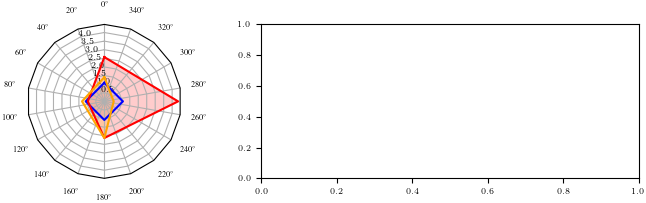

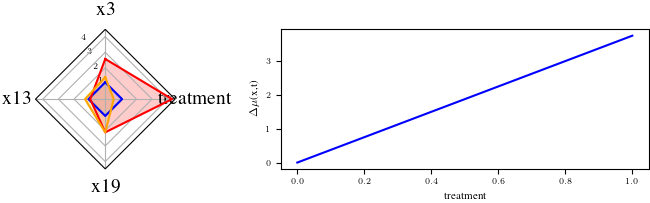

In [38]:
# now include in the same plot, the radar and the pdp of x44, with a shared legend
# the radar must have only ['x5','x7', 'x10', 'x18', 'x26', 'x35', 'x44', 'x57']

with plt.rc_context({**bundles.icml2024(column='full', ncols=2, nrows=1)}):
    fig = plt.figure()
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 1.5])
    ax1 = fig.add_subplot(gs[0, 0], projection='radar')  # radar
    ax2 = fig.add_subplot(gs[0, 1])
    important_var_index = [i for i, col in enumerate(delta_train.columns) if col in important_vars]
    delta_train_important = delta_train.iloc[:, important_var_index]
    # radar plot
    ax = ax1
    n_feats_radar = len(important_vars)
    theta_radar = radar_factory(n_feats_radar, frame='polygon')
    # ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    avg_delta = sum(np.mean(delta_train_important , axis=0)) * np.ones(n_feats_radar)
    # avg_delta = sum(np.mean(delta_train , axis=0)) * np.ones(n_feats_radar)

    # avg_delta = np.log(avg_delta)
    _ = ax.plot(theta_radar, avg_delta, label='Avg', color='b')
    ax.fill(theta_radar, avg_delta, alpha=0.1, color='b')

    avg_delta_ = delta_train_important .mean(axis=0).values[None, :]
    avg_matrix = np.repeat(avg_delta_, delta_train_important.shape[1], axis=0)

    for j, patient_id in enumerate(patient_ids):
        np.fill_diagonal(avg_matrix, delta_train_important.iloc[patient_id].values)
        pat_proba = avg_matrix.sum(axis=1)
        # pat_proba = np.log(pat_proba)
        _ = ax.plot(theta_radar, pat_proba, label=f'Individual {patient_id}', color=colors[j])
        ax.fill(theta_radar, pat_proba, alpha=0.2, color=colors[j])

    ax.set_varlabels(important_vars)
    # ax.set_title('Radar Plot', fontsize=16)

    # pdp plot
    ax = ax2
    var = 'treatment'

    # plot the value of delta_train[var] against x_train_df[var] ordered with plot
    sorted_idx = np.argsort(x_train_df[var])
    ax.plot(x_train_df[var].values[sorted_idx], delta_train[var].values[sorted_idx], color='b')
    # change the name var (format x25) to latex version x_{25}
    # var_latex = var.replace('x', 'x_{') + '}'
    ax.set_xlabel(f'treatment')

    ax.set_ylabel(r'$\Delta \mu$(x,t)')
    # ax.set_title(f'PDP for ${var_latex}$', fontsize=16)

    # represent the points of the patients of patients
    plt.show()


## Radar plot for potential outcomes of same patient

C:\Users\Alex\AppData\Local\Temp\ipykernel_31604\3003672340.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


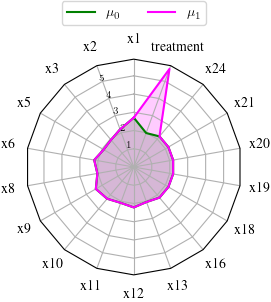

In [39]:
x_train_df_0 = x_train_df.copy()
x_train_df_0['treatment'] = 0
x_train_df_1 = x_train_df.copy()
x_train_df_1['treatment'] = 1
delta_formula_0, delta_train_0 = get_delta(x_train_df, formulas[0])
delta_formula_1, delta_train_1 = get_delta(x_train_df_1, formulas[0])

delta_train_0 = delta_train_0[0].iloc[:, :-1]
delta_train_1 = delta_train_1[0].iloc[:, :-1]

cols_delta = list(set(delta_train_0.columns).intersection(delta_train_1.columns))
# modifty cols_delta to be in the same order as x_cols
cols_delta = [col for col in x_cols if col in cols_delta]+ ['treatment']
index_of_columns = [delta_train_0.columns.get_loc(col) for col in cols_delta]
delta_train_0 = delta_train_0.iloc[index_of_columns, index_of_columns]
delta_train_1 = delta_train_1.iloc[index_of_columns, index_of_columns,]
# delta_factual = delta_factual[cols_delta]
theta = radar_factory(len(cols_delta), frame='polygon')
patient_id = 0
# set different patient colors: red and orange
colors_po = ['g', 'magenta']
with plt.rc_context({**bundles.iclr2024()}):
    fig, ax = plt.subplots(subplot_kw=dict(projection='radar'))
    # ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    avg_delta = sum(np.mean(delta_train_0, axis=0)) * np.ones(len(cols_delta))

    avg_delta_ = delta_train_0.mean(axis=0).values[None, :]
    avg_matrix = np.repeat(avg_delta_, delta_train_0.shape[1], axis=0)


    np.fill_diagonal(avg_matrix, delta_train_0.iloc[patient_id].values)
    pat_proba = avg_matrix.sum(axis=1)
    _ = ax.plot(theta, pat_proba, label=f'$\mu_0$', color=colors_po[0])
    ax.fill(theta, pat_proba, alpha=0.2, color=colors_po[0])

    np.fill_diagonal(avg_matrix, delta_train_1.iloc[patient_id].values)
    pat_proba = avg_matrix.sum(axis=1)
    _ = ax.plot(theta, pat_proba, label=f'$\mu_1$', color=colors_po[1])
    ax.fill(theta, pat_proba, alpha=0.2, color=colors_po[1])

    ax.set_varlabels(cols_delta, fontsize=10)
    # legend above the radar plot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), fontsize=10, ncol=2)
    plt.tight_layout()
    plt.savefig('visualization/radar_skaam_potential.pdf', bbox_inches='tight')
    plt.show()

## How long would the standard autosymbolic substituion have taken?

In [40]:
tic = time.time()
formula = s_kaam.interprete(lib='all', n_digit=4)
tac = time.time()
print(tac - tic)

Using library all
fixing (0,0,0) with x, r2=0.9807217717170715, c=1
fixing (0,1,0) with x, r2=0.4384002089500427, c=1
fixing (0,2,0) with sin, r2=0.99921053647995, c=2
fixing (0,3,0) with 0
fixing (0,4,0) with x, r2=0.9875376224517822, c=1
fixing (0,5,0) with x, r2=0.5168995261192322, c=1
fixing (0,6,0) with 0
fixing (0,7,0) with x, r2=1.0000009536743164, c=1
fixing (0,8,0) with x, r2=1.0000009536743164, c=1
fixing (0,9,0) with x, r2=1.0000007152557373, c=1
fixing (0,10,0) with x, r2=1.0000007152557373, c=1
fixing (0,11,0) with x, r2=1.0000005960464478, c=1
fixing (0,12,0) with x, r2=1.0000008344650269, c=1
fixing (0,13,0) with 0
fixing (0,14,0) with 0
fixing (0,15,0) with x, r2=1.0000004768371582, c=1
fixing (0,16,0) with 0
fixing (0,17,0) with x, r2=1.0000007152557373, c=1
fixing (0,18,0) with x, r2=1.0000017881393433, c=1
fixing (0,19,0) with x, r2=1.000001311302185, c=1
fixing (0,20,0) with x, r2=1.000001072883606, c=1
fixing (0,21,0) with 0
fixing (0,22,0) with 0
fixing (0,23,0) w

In [41]:
print(formula[0])

0.5294*x_1 + 0.1608*x_10 + 0.5895*x_11 - 0.1099*x_12 + 0.3351*x_13 + 0.108*x_16 - 0.1713*x_18 + 1.2755*x_19 + 0.0327*x_2 - 0.2308*x_20 - 0.0823*x_21 + 0.1115*x_24 + 3.7395*x_26 + 0.2846*x_5 - 0.034*x_6 + 1.4696*x_8 + 0.3173*x_9 + 6.2295*sin(0.3098*x_3 - 0.8054) + 6.3503


The treatment is x26, similar results